## Big Mart Sales Prediction

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# loading the dataset
train_data = pd.read_csv('G:/analytics vidhya/Big Mart sales/Train_UWu5bXk.csv')
test_data = pd.read_csv('G:/analytics vidhya/Big Mart sales/Test_u94Q5KV.csv')

#combining train and test data
dataset = pd.concat([train_data,test_data],ignore_index = True, sort = True)


### Data Exploration

In [5]:
# check how the data looks?
dataset.head()
dataset.shape

(14204, 12)

In [6]:
# summary of dataset
summary = dataset.describe()
summary

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


#### Here if we look closely, the minimum value for Item_Visibility is 0. This makes no sense because if the product is sold in the store or is available for sale in store then it's visibility cannot be 0.

#### Outlet_Establishment_Year can be coverted into age of the outlet which will have more significant impact on Target variable.

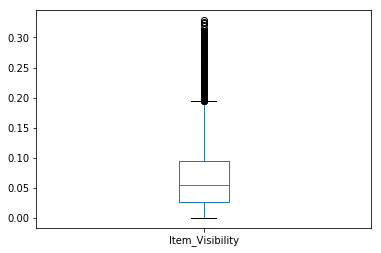

In [7]:
%matplotlib inline
dataset['Item_Visibility'].plot.box() 

In [8]:
dataset[dataset['Item_Visibility']>=0.10].shape

(3166, 12)

In [9]:
#  for categorical variables.
categorical_variables = dataset.dtypes.loc[dataset.dtypes== 'object'].index
categorical_variables

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type'],
      dtype='object')

In [10]:
dataset[categorical_variables].apply(lambda x: len(x.unique()))

Item_Fat_Content           5
Item_Identifier         1559
Item_Type                 16
Outlet_Identifier         10
Outlet_Location_Type       3
Outlet_Size                4
Outlet_Type                4
dtype: int64

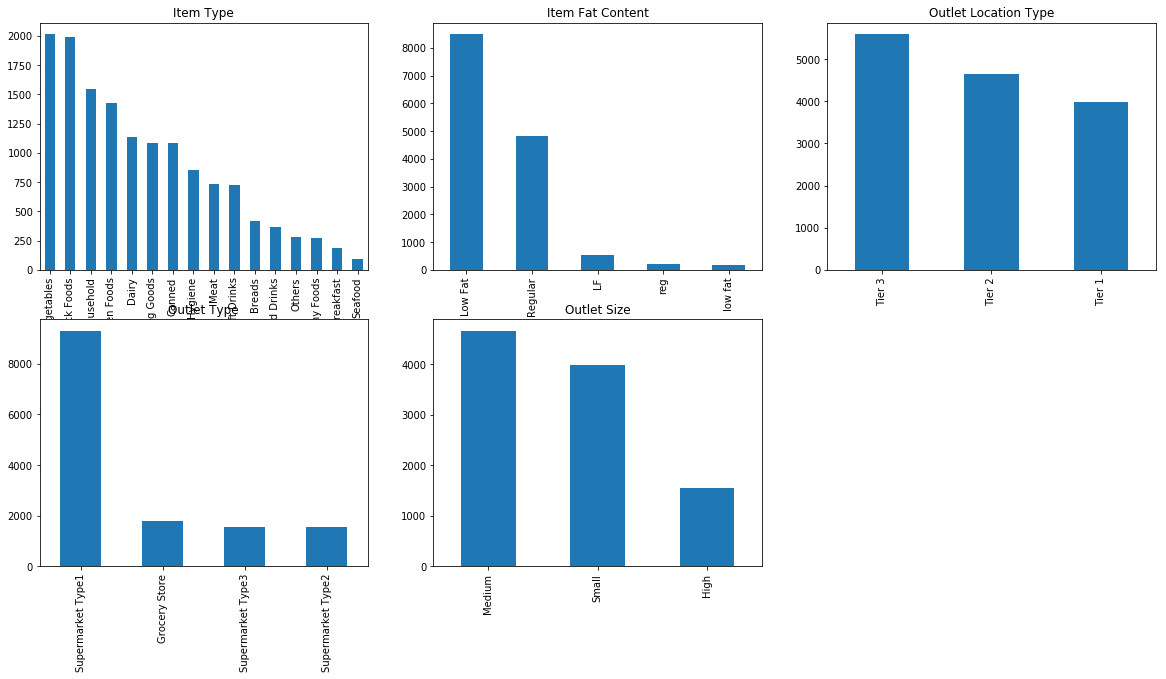

In [11]:
plt.figure(figsize = (20,10))
#plt.subplots_adjusts(hspace = 0,vspace = 0)
plt.subplot(2,3,1)
plt.title('Item Type')
dataset['Item_Type'].value_counts().plot.bar()

plt.subplot(2,3,2)
plt.title('Item Fat Content')
dataset['Item_Fat_Content'].value_counts().plot.bar()

plt.subplot(2,3,3)
plt.title('Outlet Location Type')
dataset['Outlet_Location_Type'].value_counts().plot.bar()

plt.subplot(2,3,4)
plt.title('Outlet Type')
dataset['Outlet_Type'].value_counts().plot.bar()

plt.subplot(2,3,5)
plt.title('Outlet Size')
dataset['Outlet_Size'].value_counts().plot.bar()

#### Item_Type  has many categories and many of them dont have significant numbers. So, it will be good if we combine categories to some broad categories.

#### In Item_Fat_Content column, there are only two main labels but multiple names are given. 

## Null Values

In [12]:
# checking null values for every column in a dataset
dataset.apply(lambda x: sum(x.isnull()))
# Here we see null values are present in column Item_Wieght and Outlet_Size.

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
dtype: int64

#### To impute missing values we can look for the same Item_Identifier and Outlet_Identifier for which values are present. We can replace the NaN values with the value provided for same Identifier.

#### In this case it works for Item_Weight, as we gets all the values against all missing values.

In [13]:
#Extract identifiers
items_id = dataset['Item_Identifier'].copy()
outlets_id = dataset['Outlet_Identifier'].copy()

#Concat id and weight
df_copy = pd.concat([items_id, dataset['Item_Weight']], axis='columns')
#Get null values
df_copy = df_copy[dataset['Item_Weight'].isnull()]
#Get how many nulls ids are
nulls = df_copy['Item_Identifier'].unique()

from scipy.stats import mode
for id in nulls:
    #Get value
    df_weight = dataset.loc[items_id == id, 'Item_Weight']
    value = mode(df_weight.values, nan_policy='omit').mode[0]
    
    if value == 0:
        value = np.nan #No results if mode = 0
    
    dataset.loc[(df_weight == np.nan).index, 'Item_Weight'] = value

#### For Outlet_Size, we look for the relation with Outlet_Type column and replace with mode values.

In [14]:
# cross tabulation 
ct = pd.crosstab(dataset['Outlet_Size'],dataset['Outlet_Type'],margins = True)

In [15]:
dataset.loc[dataset['Outlet_Type'] == 'Grocery Store', 'Outlet_Size'] = 'Small'
dataset.loc[dataset['Outlet_Type'] == 'Supermarket Type1', 'Outlet_Size'] = 'Small'
dataset.loc[dataset['Outlet_Type'] == 'Supermarket Type2', 'Outlet_Size'] = 'Medium'
dataset.loc[dataset['Outlet_Type'] == 'Supermarket Type3', 'Outlet_Size'] = 'Medium'

# Checking again for Null values
dataset.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
dtype: int64

## Feature Engineering

In [16]:
# Transforming the categories for Item_Fat_Content
#Transform 'LF' and 'low fat' to 'Low Fat'
dataset.loc[dataset['Item_Fat_Content'] == 'LF', 'Item_Fat_Content'] = 'Low Fat'
dataset.loc[dataset['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'Low Fat'

#Transform 'reg' to 'Regular'
dataset.loc[dataset['Item_Fat_Content'] == 'reg', 'Item_Fat_Content'] = 'Regular'

dataset['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [19]:
# Item_visibility
# Replacing 0 value with mean value in Item_Visibility for that product.
#Determine average visibility of a product
mean_visibility = dataset.pivot_table(values='Item_Visibility', index='Item_Identifier').reset_index()

#Impute 0 values with mean visibility of that product:
visibility = pd.concat([dataset['Item_Identifier'], dataset['Item_Visibility']], axis='columns', keys=['id', 'Item_Visibility'])
zero_visibility = visibility.loc[visibility['Item_Visibility'] == 0]
dataset['Item_Visibility'].describe()

for id in zero_visibility['id']:
    #print(id)
    #if id in mean_visibility:
    row = mean_visibility.loc[mean_visibility['Item_Identifier'] == id]
    value = row.iloc[0]['Item_Visibility']
    dataset.loc[dataset['Item_Identifier']== id, 'Item_Visibility'] = value

# check the values in Item_Visibility
dataset['Item_Visibility'].describe()

count    14204.000000
mean         0.065953
std          0.045966
min          0.003575
25%          0.030052
50%          0.055289
75%          0.092060
max          0.323637
Name: Item_Visibility, dtype: float64

In [20]:
#For the year column,calculating how old is a particular store is.
dataset['Outlet_Age'] = 2013 - dataset['Outlet_Establishment_Year']

In [21]:
# broad category for items
#Get the first two characters of ID:
dataset['Item_Type_Combined'] = dataset['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
dataset['Item_Type_Combined'] = dataset['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
dataset['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [22]:
# There are Items that are not consumable and we have only two column in Fat content. We try to mark Non consumable items with 'Non-Edible'.
dataset.loc[dataset['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
dataset['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [23]:
#combining Outlet_Type on the basis of sales and checking correlation
dataset.loc[dataset['Outlet_Type'] == 'Supermarket Type1', 'Outlet_Type'] = 'Supermarket Combined'
dataset.loc[dataset['Outlet_Type'] == 'Supermarket Type3', 'Outlet_Type'] = 'Supermarket Combined'
dataset['Outlet_Type'].value_counts()

Supermarket Combined    10853
Grocery Store            1805
Supermarket Type2        1546
Name: Outlet_Type, dtype: int64

## Preparing dataset for ML model

In [ ]:
# dropping columns
dataset.drop(['Item_Outlet_Sales','Outlet_Establishment_Year','Item_Type','Item_Identifier',
              'Outlet_Identifier'],axis = 1,inplace = True)

# encoding categorical values

# Outlet_Type
dataset['Outlet_Type']  = dataset['Outlet_Type'].map({'Supermarket Combined': 2, 'Supermarket Type2':1,
       'Grocery Store':0})

# Outlet_Size
dataset['Outlet_Size']  = dataset['Outlet_Size'].map({'High': 2, 'Medium': 1,'Small':0})

# rest categorical variable
dataset = pd.get_dummies(dataset)
print(dataset.head())

# Splitting dataset
X = dataset.iloc[:8523,:].values
test_data = dataset.iloc[8523:,:].values
y = train_data.iloc[:,11:12].values

# feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
test_data = sc_X.transform(test_data)
y = sc_y.fit_transform(y)

## Model fitting and Hyperparameter Tuning with Random Forest Regressor

In [26]:
#random forest classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [28]:
tree_one = RandomForestRegressor()
param_grid1 = {
    'bootstrap':[True, False],
    'max_depth': [5,6,7],
    'max_features': ['auto',5,6],
    'min_samples_leaf': [40,50,60,70],
    'n_estimators': [250,300,350,400]
}
grid_search1 = GridSearchCV(estimator = tree_one, param_grid = param_grid1, scoring = 'neg_mean_squared_error',
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search1.fit(X, y)
grid_search1.best_params_,grid_search1.best_score_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 23.6min finished
C:\Users\prashant bajetha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


({'bootstrap': True,
  'max_depth': 6,
  'max_features': 'auto',
  'min_samples_leaf': 40,
  'n_estimators': 350},
 -0.4018391689508537)

In [29]:
# Fitting RandomForestRegressor with Optimal HyperParameter
opt_rf = RandomForestRegressor(bootstrap = True, max_depth = 6, min_samples_leaf = 40,n_estimators = 350)
opt_rf.fit(X,y)

# Prediction
y_pred = opt_rf.predict(test_data)
predicted_values = sc_y.inverse_transform(y_pred)

C:\Users\prashant bajetha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# five sample sales prediction
predicted_values[:5]

array([1648.73475522, 1361.68066648,  604.35447569, 2472.42166705,
       6188.45579369])

### With this i got the RMSE score of 1152.37.